# Load Package

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

# Model Preparation

In [2]:
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    idataA = pm.sample(return_inferencedata=True)
    idataA.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataA)["y"][None,:]}})

with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(return_inferencedata=True)
    idataB.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataB)["y"][None,:]}})


with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(return_inferencedata=True)
    idataC.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataC)["y"][None,:]}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8794220855890343, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8798189126327263, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [3]:
idatas_cmp["mA"] = idataA
idatas_cmp["mB"] = idataB
idatas_cmp["mC"] = idataC

In [4]:
idatas_cmp.keys()

dict_keys(['mA', 'mB', 'mC'])

In [5]:
keys=["mA","mB"]
dict_cmp = {x:idatas_cmp[x] for x in keys}
az.compare(dict_cmp)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mB,0,-151.193013,1.230772,0.000000,1.000000e+00,8.369958,0.000000,False,log
mA,1,-177.184825,1.967335,25.991812,5.677236e-12,12.392792,6.990526,False,log


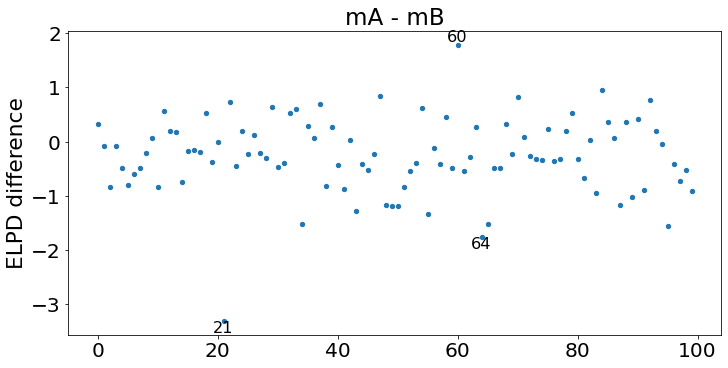

In [6]:
output=az.plot_elpd(dict_cmp,figsize=(10, 5), plot_kwargs={"marker":"."}, threshold=2)

In [7]:
output.figure.savefig('foo.png')

# Dashboard Building

In [8]:
import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
from matplotlib.figure import Figure
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvas

In [9]:
pn.extension()

In [10]:
# Structure
model_select=pn.WidgetBox()
model_selection1 = pn.widgets.Select(value=None, options = list(idatas_cmp.keys()) , name="Model1")
model_selection2 = pn.widgets.Select(value=None, options = list(idatas_cmp.keys()) , name="Model2")

str_pane = pn.pane.Str('', style={'font-size': '12pt','color':'red'})


global idatas_cmp
global str_pane

#function
@pn.depends(model_selection1.param.value, model_selection2.param.value)
def get_compare_plot(model_selection1,model_selection2):
    if model_selection1!=model_selection2:
        str_pane.object=""
        keys=[]
        keys.append(model_selection1)
        keys.append(model_selection2)
        dict_cmp = {x:idatas_cmp[x] for x in keys}
        return(az.plot_elpd(dict_cmp).figure)
    else:
        str_pane.object='Please try again. You can only compare two different models'

#show up
pn.Column(pn.Row(model_selection1,model_selection2),str_pane,get_compare_plot)

Column
    [0] Row
        [0] Select(name='Model1', options=['mA', 'mB', 'mC'], value='mA')
        [1] Select(name='Model2', options=['mA', 'mB', 'mC'], value='mA')
    [1] Str(str, style={'font-size': '12pt', ...})
    [2] ParamFunction(function)

# Bokeh

In [11]:
import arviz as az
ax = az.plot_elpd(dict_cmp, backend="bokeh")

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "marker" value "Cross" [renderer: GlyphRenderer(id='1049', ...)]
